# Nighttime Lights Exploratory Data Analysis

This notebook contains the exploratory data analysis of the nighttime lights 2016 dataset and generates CSV files required for splitting the images into training and validation datasets. 

After running the contents of this notebook and generating the necessary files, you may download the GSM images using the script: `src/data_download.py`.

## Imports and Setup

In [1]:
import sys
sys.path.insert(0, '../utils')
import warnings
warnings.filterwarnings('ignore')

import os
import time
import copy
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import data_utils

SEED = 42
np.random.seed(SEED)

%matplotlib inline
TM_pal_categorical_3 = ('#ef4631', '#10b9ce', '#ff9138')
sns.set(style='white', font_scale=1, palette=TM_pal_categorical_3)

%load_ext autoreload
%autoreload 2

## File Locations

In [2]:
# Input data file paths
data_path = '../data/'
nightlights_file = data_path + 'nightlights.csv'
dhs_indicators_file = data_path + 'dhs_indicators.csv'

# Output data file paths 
nightlights_unstacked_file = data_path + 'nightlights_unstacked.csv'
nightlights_bins_file = data_path + 'nightlights_bins.csv'
nightlights_train_file = data_path + 'nightlights_train.csv'
nightlights_train_bal_file = data_path + 'nightlights_train_bal.csv' #balanced training set
nightlights_val_file = data_path + 'nightlights_val.csv'

## Night Time Lights Dataset EDA

### Load Nighttime Lights Dataset

In [3]:
nightlights = pd.read_csv(nightlights_file)
print('Number of images to download: {} \n'.format(nightlights.ID.nunique()))
nightlights.tail(3)

Number of images to download: 134540 



,ID,DHSCLUST,ntllon,ntllat,ntl2016,pop_sum
134537,323239,PH201700000726,122.683334,12.341666,0.00000,483.555064
134538,323240,PH201700000726,122.687501,12.362499,0.17369,141.463403
134539,323241,PH201700000726,122.687501,12.358333,0.11054,443.106126


### Sanity check number of pixels by nighttime light intensity

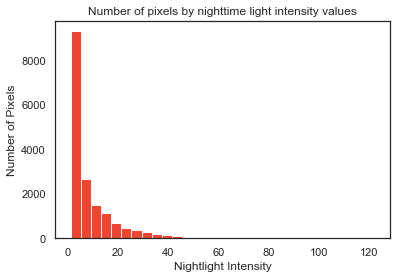

In [4]:
data_utils.plot_hist(
    nightlights[nightlights['ntl2016'] > 1]['ntl2016'],
    title='Number of pixels by nighttime light intensity values', 
    x_label='Nightlight Intensity', 
    y_label='Number of Pixels'
)

### Unstack Nighttime Lights Dataset
Unstack dataset so that each row consists of a unique (cluster, lat, lon) tuple.

In [5]:
nightlights = data_utils.unstack_clusters(nightlights)
nightlights.to_csv(nightlights_unstacked_file)
print("Total number of pixels (including duplicates belonging to different clusters): {}".format(len(nightlights)))

100%|██████████| 134540/134540 [00:26<00:00, 5114.73it/s]


Total number of pixels (including duplicates belonging to different clusters): 173580


### Sanity Check DHS Clusters and Nighttime Lights Summary Statistics

In [6]:
print("Number of unique clusters in night lights dataset: ", nightlights['DHSCLUST'].nunique())
nightlights['ntl2016'].describe()

Number of unique clusters in night lights dataset:  1214


count    173580.000000
mean          2.055890
std           7.030332
min           0.000000
25%           0.000000
50%           0.000000
75%           0.324230
max         122.432310
Name: ntl2016, dtype: float64

### Sanity Check Number of Pixels/Images Per Cluster

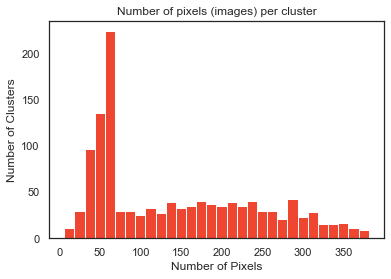

In [7]:
data_utils.plot_hist(
    nightlights.groupby('DHSCLUST').count()['ntl2016'],
    title='Number of pixels (images) per cluster', 
    x_label='Number of Pixels', 
    y_label='Number of Clusters'
)

### Sanity Check Proportion of Zero Intensity Levels in the Dataset

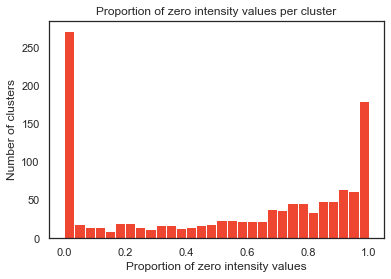

Around 150 clusters have ~100% zero night light intensity values (total darkness).
Percent of zero intensity pixels in dataset: 66%


In [8]:
nightlights_zero = nightlights.groupby(['DHSCLUST', 'ntl2016']).size().unstack(fill_value=0)
data_utils.plot_hist(
    nightlights_zero[0.0]/nightlights_zero.sum(axis=1),
    title='Proportion of zero intensity values per cluster', 
    x_label='Proportion of zero intensity values', 
    y_label='Number of clusters'
)
print("Around 150 clusters have ~100% zero night light intensity values (total darkness).")
percent_zeros = nightlights[nightlights['ntl2016'] == 0].shape[0]/len(nightlights)
print("Percent of zero intensity pixels in dataset: {:.0f}%".format(percent_zeros*100))

### Sanity Check Average Nighttime Lights Per Cluster

Shape of average night lights dataframe:  (1214, 2)


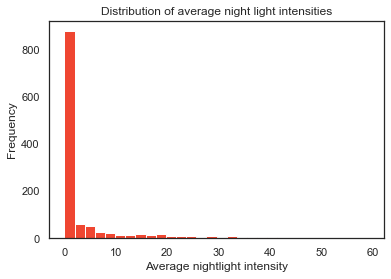

In [9]:
nightlights_avg = pd.DataFrame(nightlights.groupby(['DHSCLUST'])['ntl2016'].mean()).reset_index()
print("Shape of average night lights dataframe: ", nightlights_avg.shape)
data_utils.plot_hist(
    nightlights_avg['ntl2016'],
    title='Distribution of average night light intensities', 
    x_label='Average nightlight intensity', 
    y_label='Frequency'
)

### Get Sum of Population Per Cluster

Shape of population dataframe:  (1214, 2)


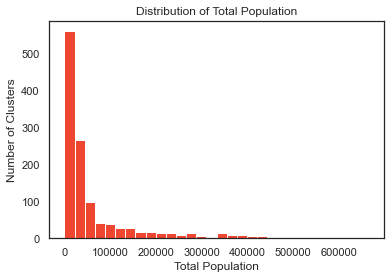

In [10]:
pop_sum = pd.DataFrame(nightlights.groupby(['DHSCLUST'])['pop_sum'].sum()).reset_index()
print("Shape of population dataframe: ", pop_sum.shape)
data_utils.plot_hist(
    pop_sum['pop_sum'],
    title='Distribution of Total Population', 
    x_label='Total Population', 
    y_label='Number of Clusters'
)

## Demographic and Health Survey (DHS) Dataset EDA

### Load DHS indicators 
Load DHS dataste and merge with average night time lights data.

In [27]:
dhs_indicators = pd.read_csv(dhs_indicators_file)
dhs_indicators.head(2)
# nightlights_avg = nightlights_avg.merge(dhs_indicators, left_on='DHSCLUST', right_on='Cluster number')
# pop_sum = pop_sum.merge(dhs_indicators, left_on='DHSCLUST', right_on='Cluster number')

# print("Number of unique clusters in DHS data merged with NTL data: ", nightlights_avg['DHSCLUST'].nunique())
# print("Number of unique clusters in DHS data merged with pop data: ", pop_sum['DHSCLUST'].nunique())

,Cluster number,Wealth Index,Education completed (years),Access to electricity,Access to water (minutes)
0,1,-31881.608696,9.391304,0.913043,0.0
1,2,-2855.375000,9.708333,0.958333,0.0


### Correlations bet. Average NTL Intensity and Socioeconomic Indicators

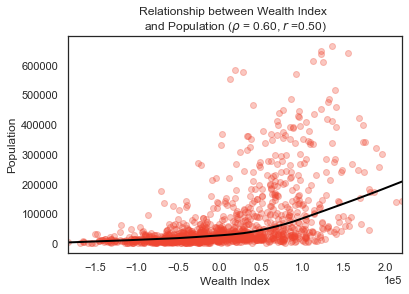

In [23]:
data_utils.plot_regplot(pop_sum, 'Wealth Index', 'Population', 'pop_sum')

In [29]:
data_utils

<module 'data_utils' from '../utils/data_utils.py'>

In [30]:
nightlights_avg

,DHSCLUST,ntl2016,Cluster number_x,Wealth Index_x,Education completed (years)_x,Access to electricity_x,Access to water (minutes)_x,Cluster number_y,Wealth Index_y,Education completed (years)_y,Access to electricity_y,Access to water (minutes)_y
0,1,0.179227,1,-31881.608696,9.391304,0.913043,0.0,1,-31881.608696,9.391304,0.913043,0.0
1,2,0.224196,2,-2855.375000,9.708333,0.958333,0.0,2,-2855.375000,9.708333,0.958333,0.0
2,3,0.042655,3,-57647.047619,8.428571,0.857143,0.0,3,-57647.047619,8.428571,0.857143,0.0
3,4,0.001873,4,-54952.666667,6.714286,0.809524,0.0,4,-54952.666667,6.714286,0.809524,0.0
4,6,0.000000,6,-80701.695652,8.086957,0.869565,10.0,6,-80701.695652,8.086957,0.869565,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1208,1246,0.066377,1246,-45677.120000,9.040000,1.000000,0.0,1246,-45677.120000,9.040000,1.000000,0.0
1209,1247,0.000000,1247,-135111.920000,4.240000,0.880000,10.0,1247,-135111.920000,4.240000,0.880000,10.0
1210,1248,0.374840,1248,-14459.166667,7.875000,1.000000,0.0,1248,-14459.166667,7.875000,1.000000,0.0
1211,1249,0.012396,1249,-51500.272727,9.045455,0.909091,0.0,1249,-51500.272727,9.045455,0.909091,0.0


In [24]:
data_utils.plot_regplot(nightlights_avg, 'Wealth Index')

KeyError: 'Wealth Index'

In [ ]:
data_utils.plot_regplot(nightlights_avg, 'Education completed (years)')

In [ ]:
data_utils.plot_regplot(nightlights_avg, 'Access to electricity')

In [28]:
data_utils.plot_regplot(nightlights_avg, 'Access to water (minutes)')

KeyError: 'Access to water (minutes)'

## Binning Nighttime Light Intensities

###  Load Nighttime Lights Dataset

In [26]:
nightlights = pd.read_csv(nightlights_file)
nightlights.head(3)

,ID,DHSCLUST,ntllon,ntllat,ntl2016,pop_sum
0,0,"PH201700000387, PH201700000395",120.554167,18.212500,0.49878,446.725863
1,3,"PH201700000395, PH201700000387",120.554167,18.200000,0.29817,16.787817
2,4,"PH201700000387, PH201700000395",120.554167,18.195833,0.63710,151.090350


### Gaussian Mixture Model

In [ ]:
bin_labels = ['low', 'low medium', 'medium', 'high medium', 'high']
nightlights = data_utils.gaussian_mixture_model(nightlights, n_components=5, bin_labels=bin_labels)
for label in bin_labels:
    print(
        "Number of {} intensity pixels: {}".format(
            label, nightlights[nightlights['label'] == label]['ntl2016'].count()
        )
    )

### Ad Hoc Label Assignment

In [ ]:
bin_caps = [0, 2, 15, 30]
bin_labels = ['low', 'low medium', 'medium', 'high medium', 'high']
nightlights['label'] = nightlights['ntl2016'].apply(lambda x: data_utils.ad_hoc_binning(x, bin_caps, bin_labels))
print(nightlights[nightlights['label'] == 'high medium']['ntl2016'].describe())
for label in bin_labels:
    print(
        "Number of {} intensity pixels: {}".format(
            label, nightlights[nightlights['label'] == label]['ntl2016'].count()
        )
    )

### Save Binned Dataset

In [ ]:
nightlights.to_csv(nightlights_bins_file, index=False)

print('Total number of images: ', nightlights.shape[0])
print(nightlights['label'].value_counts())
print(nightlights['label'].value_counts()/nightlights.shape[0])

## Balancing Nighttime Lights Intensity Levels

### Load Nighttime Lights Dataset

In [ ]:
nightlights = pd.read_csv(nightlights_bins_file)
print('Total number images downloaded: ', len(nightlights))

### Shuffle NTL Dataset and Split into Train/Val Sets

In [ ]:
nightlights = nightlights.sample(frac=1, random_state=SEED).reset_index(drop=True)
train, val = data_utils.train_val_split(nightlights, train_size=0.9)
print('Size of training set: ', len(train))
print(train['label'].value_counts())
print('\nSize of validation set: ', len(val))
print(val['label'].value_counts())

### Upsample Minority Class of Training Set

In [ ]:
train_balanced = data_utils.balance_dataset(train, size=30000)
print('Number of images in training set (balanced): ', len(train_balanced))
train_balanced['label'].value_counts()

## Downloading the Google Static Maps (GSM) Images

To download the GSM images, run `src/data_download.py` as follows:
```
cd src
python data_download.py
```